In [89]:
from utils.load_dataset import PlantVillageDataset
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from utils.preprocessing import preprocessing_img
import torchvision.models  as models
from torchvision import transforms

## Vizualize the data

In [90]:
# Load the dataset
PATH = './Plant_leave_diseases_dataset_without_augmentation'
transform = transforms.Compose([
    preprocessing_img,
    transforms.ToTensor(),
])
training_data = PlantVillageDataset(PATH, img_mode="LAB", train=True, transform=transform)
test_data = PlantVillageDataset(PATH, img_mode="LAB", train=False, transform=transform)

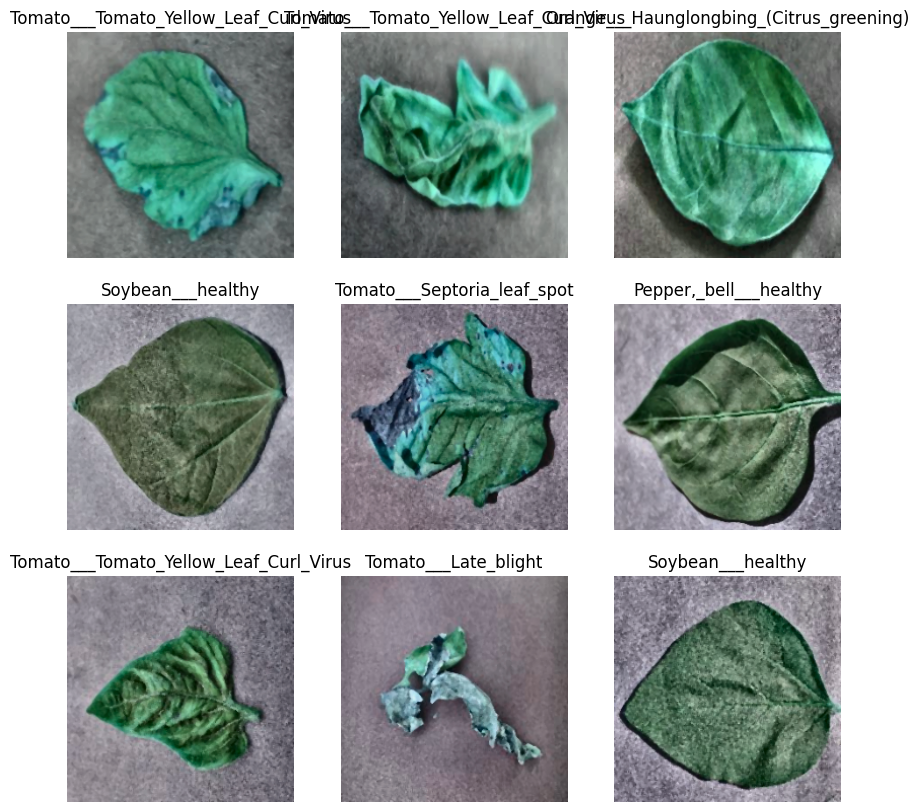

In [91]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(list(training_data.label_to_idx.keys())[label])
    plt.axis("off")
    plt.imshow(img.swapaxes(0,2))
plt.show()

## Create Loaders

In [92]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Load Models

In [93]:
# ResNet50
resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')
for param in resnet50.parameters():
    param.requires_grad = False

# DenseNet201
densenet = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)
for param in densenet.parameters():
    param.requires_grad = False

# EfficientNetB0
efficientnet_b0 = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
for param in efficientnet_b0.parameters():
    param.requires_grad = False

# EfficientNetB3
efficientnet_b3 = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
for param in efficientnet_b3.parameters():
    param.requires_grad = False

## Set Device

In [94]:
# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Linear Model

In [113]:
# Linear Model
import torch.nn as nn
class LinearHeadModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, dropout_rate=0.25):
        super(LinearHeadModel, self).__init__()
        #self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.batch_norm = nn.BatchNorm1d(input_dim)
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.Dropout(dropout_rate),
            nn.Linear(64, output_dim),
            nn.Softmax(1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.batch_norm(x)
        x = self.linear_layers(x)
        return x

## Train Model

In [109]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

In [98]:
# Hyperparameters
input_dim = 224 * 224 * 3
num_classes = 38

In [142]:
def train_linear_model(pre_trained_model, input_dim, num_classes):
    
    # Set model to device
    pre_trained_model = pre_trained_model.to(device)

    # Create linear head model and add it to the pre-trained-model
    model_linear_classifier = LinearHeadModel(input_dim, num_classes + 1)
    pre_trained_model.fc = model_linear_classifier.to(device)

    # Train model
    train_model(model_linear_classifier, train_dataloader, nn.CrossEntropyLoss(), torch.optim.Adam(pre_trained_model.fc.parameters(), lr=0.001))
    
    return model_linear_classifier

## Train models

### ResNet50

In [ ]:
resnet50_classifier = train_linear_model(resnet50, input_dim, num_classes)

### Densenet

In [126]:
densenet_classifier = train_linear_model(densenet, input_dim, num_classes)

Epoch 1/10, Loss: 2.4859519208316296
Epoch 2/10, Loss: 2.5205496685727655
Epoch 3/10, Loss: 3.0540557457638995
Epoch 4/10, Loss: 3.037257048222983
Epoch 5/10, Loss: 2.9925304385892524
Epoch 6/10, Loss: 2.9927638319536887
Epoch 7/10, Loss: 3.1146439089769586
Epoch 8/10, Loss: 3.1548320125131046
Epoch 9/10, Loss: 3.2272741351848104
Epoch 10/10, Loss: 3.2218958116045187


### EfficientNetB0

In [135]:
efficientnet_b0_classifier = train_linear_model(efficientnet_b0, input_dim, num_classes)

Epoch 1/10, Loss: 2.5871011516489646
Epoch 2/10, Loss: 3.229194164276123
Epoch 3/10, Loss: 3.349847119847246
Epoch 4/10, Loss: 3.0561952821936162
Epoch 5/10, Loss: 2.992652009790194
Epoch 6/10, Loss: 2.9576720402177505
Epoch 7/10, Loss: 3.020655544021413
Epoch 8/10, Loss: 3.048645699587935
Epoch 9/10, Loss: 3.0917736199762857
Epoch 10/10, Loss: 3.1527181986156494


### EfficientNetB3

In [ ]:
efficientnet_b3_classifier = train_linear_model(efficientnet_b3, input_dim, num_classes)

## Save models

In [115]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Final model saved to {path}")

In [116]:
# Paths for saving
densenet201_path = "densenet201.pth"
efficientnet_b0_path = "efficientnet_b0.pth"
efficientnet_b3_path = "efficientnet_b3.pth"
resnet50_path = "resnet50.pth"

In [ ]:
save_model(resnet50_classifier.fc, f'models/{resnet50_path}')
save_model(densenet_classifier.fc, f'models/{densenet201_path}')
save_model(efficientnet_b0_classifier.fc, f'models/{efficientnet_b0_path}')
save_model(efficientnet_b3_classifier.fc, f'models/{efficientnet_b3_path}')

Final model saved to models/resnet50.pth
Final model saved to models/densenet201.pth
Final model saved to models/efficientnet_b0.pth
Final model saved to models/efficientnet_b3.pth
